In [ ]:
## 以下脚本用于部署 Allin1 WebUI GUI

## 1. 代码及Web环境准备

In [1]:
%%bash
sudo chown -R ec2-user:ec2-user .
docker logout public.ecr.aws

Removing login credentials for public.ecr.aws


In [2]:
!git clone --recurse-submodules -j8 https://PRIVATE_TOKEN@github.com/xieyongliang/all-in-one-ai.git

Cloning into 'all-in-one-ai'...
remote: Enumerating objects: 41898, done.
remote: Counting objects: 100% (847/847), done.
remote: Compressing objects: 100% (302/302), done.
remote: Total 41898 (delta 560), reused 776 (delta 510), pack-reused 41051
Receiving objects: 100% (41898/41898), 1.11 GiB | 23.19 MiB/s, done.
Resolving deltas: 100% (9853/9853), done.
Updating files: 100% (6016/6016), done.
Submodule 'sagemaker/stable-diffusion-webui/stable-diffusion-webui' (https://github.com/xieyongliang/stable-diffusion-webui.git) registered for path 'sagemaker/stable-diffusion-webui/stable-diffusion-webui'
Cloning into '/home/ec2-user/SageMaker/Allin1-Deploy/all-in-one-ai/sagemaker/stable-diffusion-webui/stable-diffusion-webui'...
remote: Enumerating objects: 22655, done.        
remote: Counting objects: 100% (20/20), done.        
remote: Compressing objects: 100% (19/19), done.        
remote: Total 22655 (delta 1), reused 11 (delta 1), pack-reused 22635        
Receiving objects: 100% (226

In [ ]:
import boto3,os
account_id = boto3.client("sts").get_caller_identity().get("Account")
region_name = boto3.session.Session().region_name
os.chdir('/home/ec2-user/SageMaker/Allin1-Deploy/all-in-one-ai/deployment')
s3uri = os.getenv('s3uri')
cmd = "/bin/sh ./build_and_deploy.sh s3://%s %s stable-diffusion-webui >>bb.log" %(s3uri,region_name)
print (cmd)
os.system(cmd)

In [3]:
%%bash
all_az=()
cfn=$(aws s3 presign s3://$s3uri/templates/all-in-one-ai-webui-main.yaml | cut -d '?' -f 1)
az_per_region=$(aws ec2 describe-availability-zones --query 'AvailabilityZones[*].[ZoneName]' --output text | sort)                                                                             
  while read -r az; do                                                             
     all_az+=($az)                                                                  
  done <<< "$az_per_region" 

aws cloudformation create-stack --stack-name allin1ai-gui1 \
    --template-url $cfn \
    --parameters \
    ParameterKey=WebUIDomainName,ParameterValue="" \
    ParameterKey=UserPoolDomain,ParameterValue="" \
    ParameterKey=DomainName,ParameterValue="" \
    ParameterKey=CognitoRegion,ParameterValue="" \
    ParameterKey=UserPool,ParameterValue="" \
    ParameterKey=UserPoolClient,ParameterValue="" \
    ParameterKey=Certificate,ParameterValue="" \
    ParameterKey=AvailabilityZones,ParameterValue=${all_az[0]}\\,${all_az[1]}\\,${all_az[2]} \
    ParameterKey=S3Bucket,ParameterValue=$s3uri \
    ParameterKey=S3Key,ParameterValue="" \
    --capabilities CAPABILITY_NAMED_IAM

{
    "StackId": "arn:aws:cloudformation:ap-northeast-1:807503955397:stack/allin1ai-gui1/05b1fa60-036e-11ee-a377-0e7b3d737ad1"
}


In [15]:
!aws cloudformation describe-stacks --stack-name allin1ai-gui1 --output json --query 'Stacks[0].StackStatus'

"CREATE_COMPLETE"


In [ ]:
#WebUI登录地址

In [24]:
!aws cloudformation describe-stacks --stack-name allin1ai-gui1 --output text --query 'Stacks[0].Outputs[?OutputKey==`WebUIPortalUrl`].OutputValue'

http://all-in-one-ai-webui-2026785571.ap-northeast-1.elb.amazonaws.com


In [ ]:
#Portal登录地址

In [31]:
!aws cloudformation describe-stacks --stack-name allin1ai-gui1 --output text --query 'Stacks[0].Outputs[?OutputKey==`WebPortalUrl`].OutputValue'

http://all-in-one-ai-1790565484.ap-northeast-1.elb.amazonaws.com


In [ ]:
#检查终端节点部署状态,状态转换为complete后进行下一步

## 2. 上传预处理模型

In [46]:
import sagemaker
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()

如果启动时只选机型和数量，则可以通过动态加载默认S3中的模型⽂件。
Sagemaker节点启动成功后, 每30s从默认的s3 位置s3://sagemaker-{region_name}-
{account_id}/stable-diffusion-webui/models/同步模型⽂件到sagemaker节点的本地⽬录下。⽀
持Stable-diffusion, Lora, ControlNet模型的动态加载同步。如：

• s3://$bucket/stable-diffusion-webui/models/Stable-diffusion/

• s3://$bucket/stable-diffusion-webui/models/ControlNet/

• s3://$bucket/stable-diffusion-webui/models/Lora/


In [47]:
%%bash
cd ~/SageMaker/Allin1-Deploy/all-in-one-ai/sagemaker/stable-diffusion-webui/tools
mkdir -p models/Stable-diffusion
mkdir -p models/ControlNet
mkdir -p models/Lora
mkdir -p models/Vae

In [ ]:
#下载Stable-diffusion模型

In [ ]:
%%bash
cd ~/SageMaker/Allin1-Deploy/all-in-one-ai/sagemaker/stable-diffusion-webui/tools/models/Stable-diffusion
wget https://huggingface.co/runwayml/stable-diffusion-v1-5/resolve/main/v1-5-pruned-emaonly.ckpt
wget https://huggingface.co/runwayml/stable-diffusion-v1-5/resolve/main/v1-5-pruned.ckpt

In [56]:
#下载ControlNet模型(根据需要下载)

In [57]:
%%bash
cd ~/SageMaker/Allin1-Deploy/all-in-one-ai/sagemaker/stable-diffusion-webui/tools/models/ControlNet

In [58]:
#下载Lora模型(根据需要下载)

In [ ]:
%%bash
cd ~/SageMaker/Allin1-Deploy/all-in-one-ai/sagemaker/stable-diffusion-webui/tools/models/Lora
wget https://huggingface.co/opsopus/taiwanDollLikeness/resolve/main/taiwanDollLikeness_v10.safetensors

In [ ]:
#下载Vae模型(根据需要下载)

In [60]:
%%bash
cd ~/SageMaker/Allin1-Deploy/all-in-one-ai/sagemaker/stable-diffusion-webui/tools/models/Vae

In [61]:
#上传模型

In [74]:
import boto3,os
region_name = boto3.session.Session().region_name
os.chdir('/home/ec2-user/SageMaker/Allin1-Deploy/all-in-one-ai/sagemaker/stable-diffusion-webui/tools')
s3uri = os.getenv('s3uri')
cmd = "/bin/sh ./prepare.sh %s" %(region_name)
print (cmd)
os.system(cmd)

/bin/sh ./prepare.sh ap-northeast-1


make_bucket failed: s3://sagemaker-ap-northeast-1-807503955397 An error occurred (BucketAlreadyOwnedByYou) when calling the CreateBucket operation: Your previous request to create the named bucket succeeded and you already own it.


Uploading models/ to s3://sagemaker-ap-northeast-1-807503955397/stable-diffusion-webui/models/
cp models/Lora/taiwanDollLikeness_v10.safetensors s3://sagemaker-ap-northeast-1-807503955397/stable-diffusion-webui/models/Lora/taiwanDollLikeness_v10.safetensors
cp models/Stable-diffusion/v1-5-pruned-emaonly.ckpt s3://sagemaker-ap-northeast-1-807503955397/stable-diffusion-webui/models/Stable-diffusion/v1-5-pruned-emaonly.ckpt
cp models/Stable-diffusion/v1-5-pruned.ckpt s3://sagemaker-ap-northeast-1-807503955397/stable-diffusion-webui/models/Stable-diffusion/v1-5-pruned.ckpt


0

## 3. 部署推理节点

In [ ]:
#获取Portal地址,部署推理节点

In [ ]:
!aws cloudformation describe-stacks --stack-name allin1ai-gui1 --output text --query 'Stacks[0].Outputs[?OutputKey==`WebPortalUrl`].OutputValue'

进入Portal登录地址,在左侧,行业模型--概览中,点击开始体验,
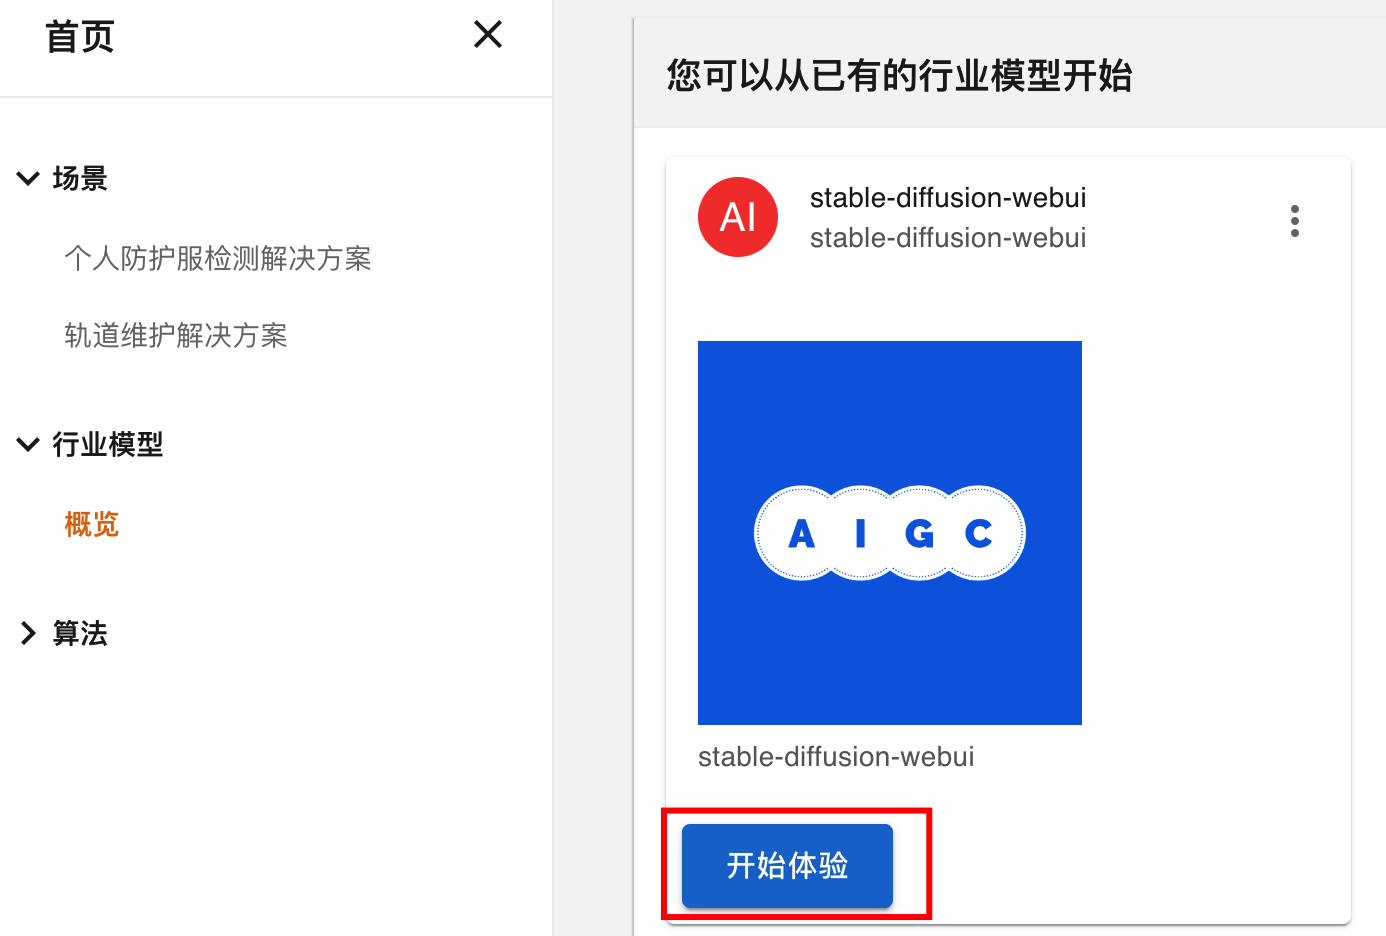
点击部署,在部署设置中,选择实例类型(推荐G5.2xlarge)和实例数量
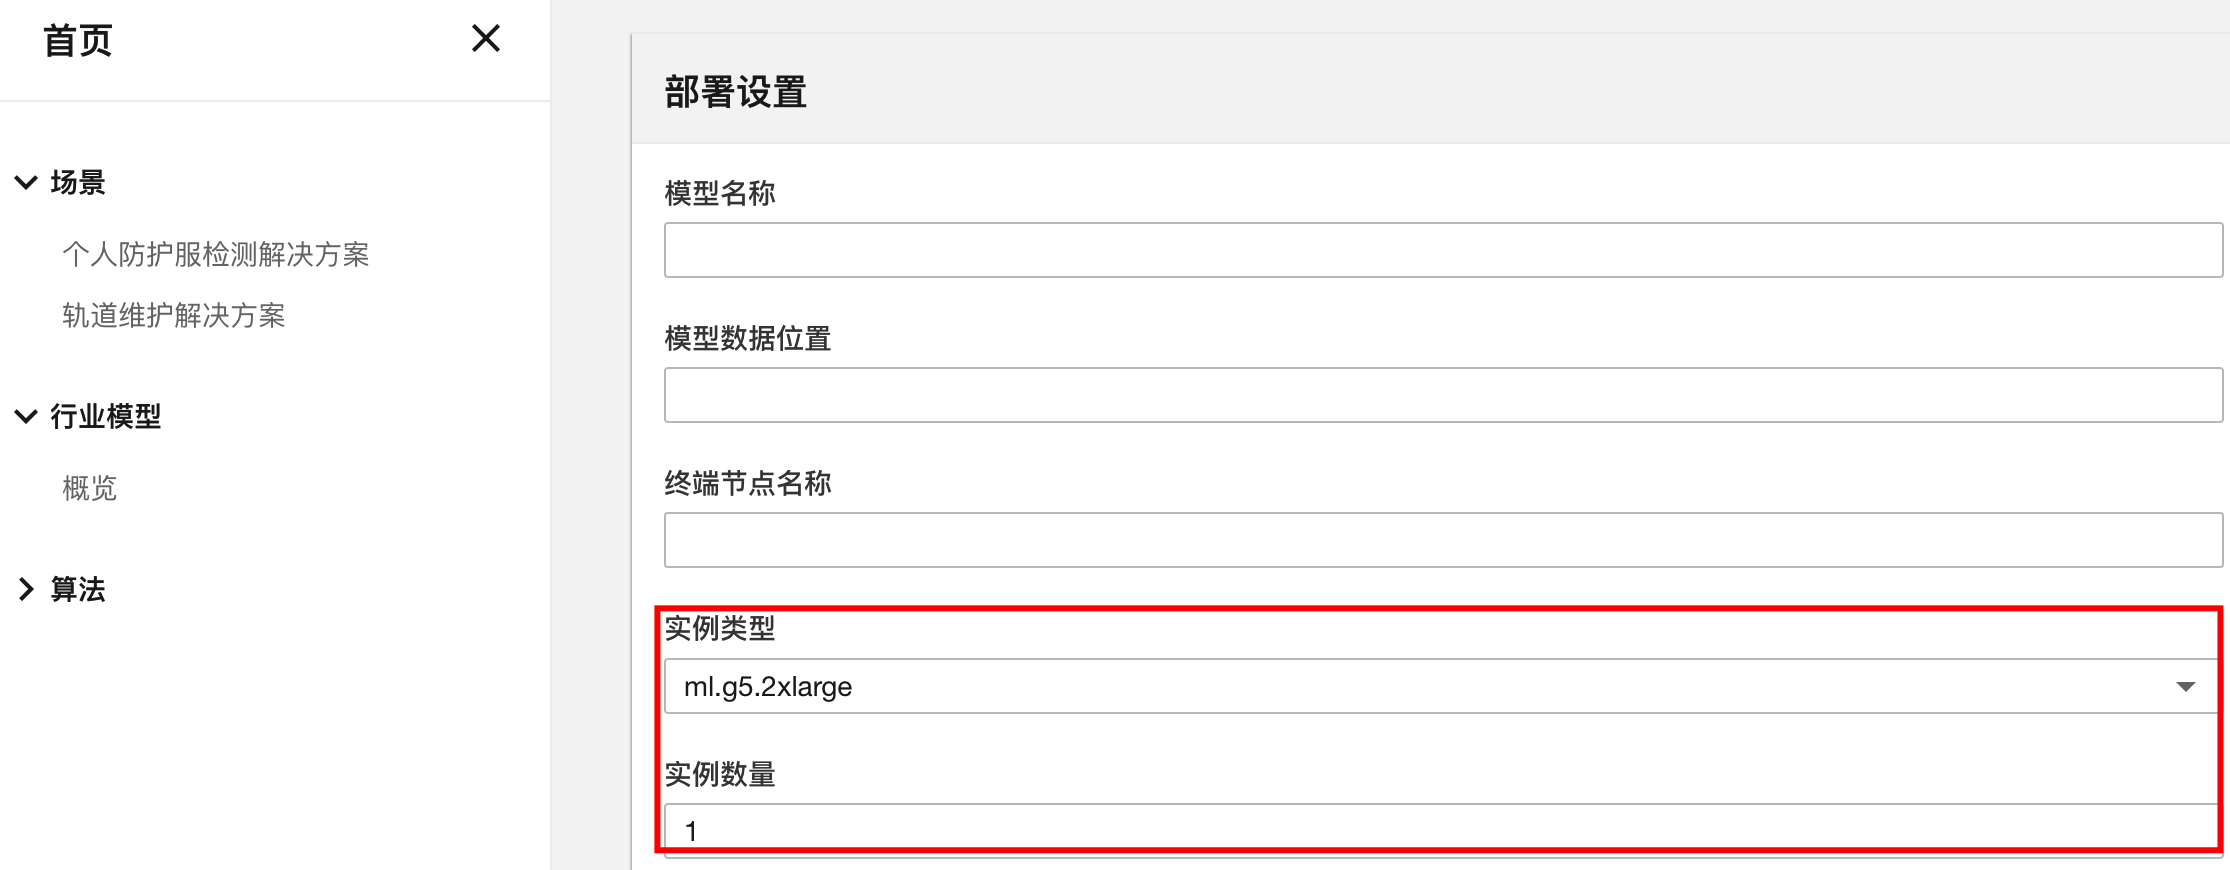
点击提交等待创建完毕.

In [ ]:
!aws sagemaker list-endpoints

In [ ]:
#等待 EndpointStatus 变为 InService 即可进行下一步

## 登录Web UI

In [ ]:
#获取登录信息

In [112]:
Admin_info = "Administratorlogin-"+"$(aws cloudformation describe-stacks --stack-name allin1ai-gui1 --output text --query 'Stacks[0].Outputs[?OutputKey==`Administratorlogin`].OutputValue'| cut -d '-' -f4)"

In [ ]:
#获取登录密码

In [ ]:
!/home/ec2-user/SageMaker/Allin1-Deploy/all-in-one-ai/sagemaker/stable-diffusion-webui/tools/secretmanager.sh $Admin_info $region_name get

In [ ]:
#记录下以上输出的密码和账号

In [ ]:
#获取登录 WebUI

In [88]:
!aws cloudformation describe-stacks --stack-name allin1ai-gui1 --output text --query 'Stacks[0].Outputs[?OutputKey==`WebUIPortalUrl`].OutputValue'

http://all-in-one-ai-webui-2026785571.ap-northeast-1.elb.amazonaws.com


登录完成后进入用户管理

创建用户及密码,点击保存登出即可

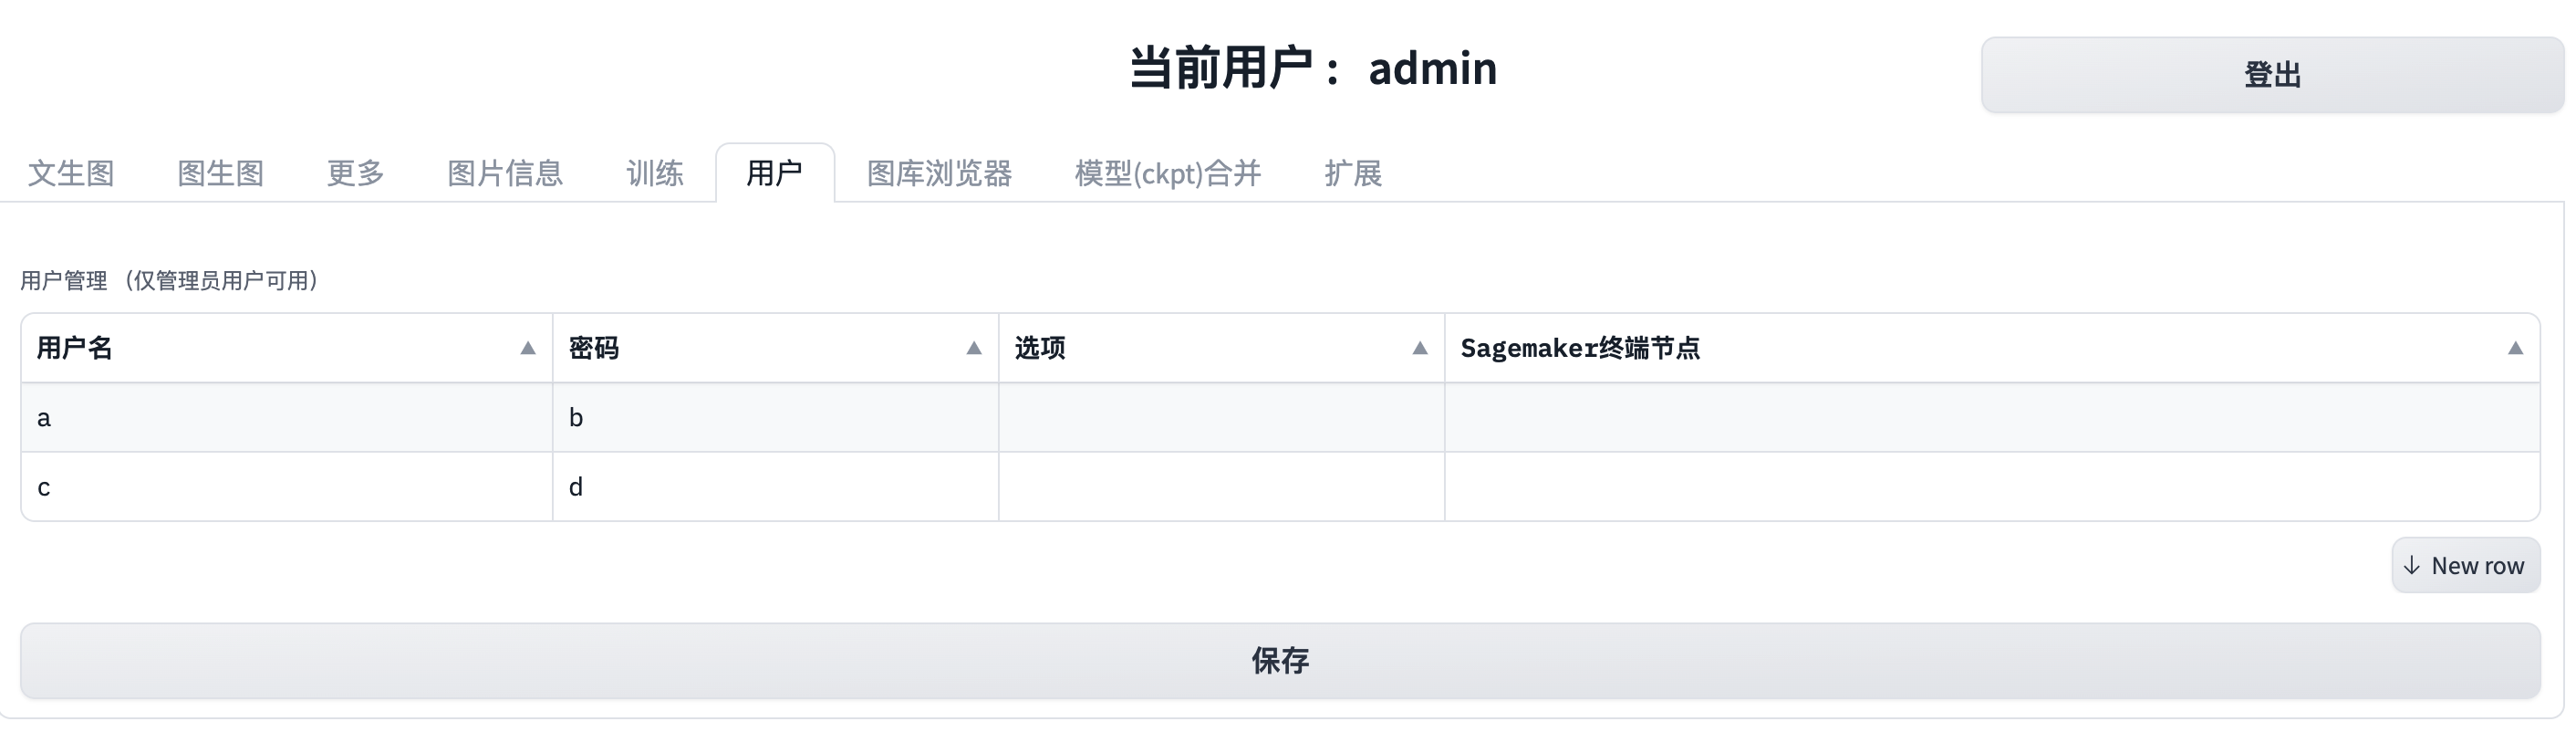

In [ ]:
#进入后请在设置中配置终端节点和模型,保存后开始使用.